# UdaciSense: Optimized Object Recognition

## Notebook 4: Mobile Deployment

In this notebook, you'll prepare your optimized model for mobile deployment.
You'll explore how to convert your best optimized model to a cross-platform mobile-friendly format,
and evaluate the performance that UdaciSense mobile users can expect.

In [1]:
# Make sure that libraries are dynamically re-loaded if changed
%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary libraries
# NOTE: This notebook lives in UdaciSense/notebooks/, so we add the parent dir to PYTHONPATH
# to make `utils` and `compression` importable.
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"✅ Added {parent_dir} to Python path")
else:
    print(f"✅ Parent directory already in path")

import copy
import json
import time
import numpy as np
import pandas as pd
import pprint
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.quantization
from typing import Dict, Any, List, Tuple, Optional, Union, Callable
import warnings

from utils.data_loader import get_household_loaders, get_input_size, print_dataloader_stats, visualize_batch
from utils.model import MobileNetV3_Household, load_model, save_model, print_model_summary
from utils.visualization import (
    plot_model_comparison, plot_multiple_models_comparison,
    create_model_summary_dashboard,
)
from utils.compression import is_quantized
from utils.evaluation import evaluate_model_metrics, compare_models
from utils.mobile_deployment import get_model_file_size  # handy for file size on disk

✅ Added /home/lence/msai/UdaciSense to Python path


In [3]:
# Ignore PyTorch deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
warnings.filterwarnings("ignore", category=UserWarning)  # Optional: Ignore all user warnings

### Step 1: Set up the Environment

In [4]:
# Check if CUDA is available
devices = ["cpu"]
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    devices.extend([f"cuda:{i} ({torch.cuda.get_device_name(i)})" for i in range(num_devices)])
print(f"Devices available: {devices}")

Devices available: ['cpu', 'cuda:0 (NVIDIA GeForce RTX 3080 Ti)']


In [5]:
# Setup directories
os.makedirs("../models/mobile", exist_ok=True)
os.makedirs("../results/mobile", exist_ok=True)

In [6]:
# Set random seed for reproducibility
def set_deterministic_mode(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    return seed_worker

set_deterministic_mode(42)
g = torch.Generator()
g.manual_seed(42)

### Step 2: Load the dataset

Extracting household classes from CIFAR100 for train set...
Extracting household classes from CIFAR100 for test set...
Input has size: (1, 3, 32, 32)
Datasets have these classes: 
  0: clock
  1: keyboard
  2: lamp
  3: telephone
  4: television
  5: bed
  6: chair
  7: couch
  8: table
  9: wardrobe

Information on train set
Statistics for train
 Size: 5000
 Samples per class:
  clock: 500
  keyboard: 500
  lamp: 500
  telephone: 500
  television: 500
  bed: 500
  chair: 500
  couch: 500
  table: 500
  wardrobe: 500
Examples of images from the train set


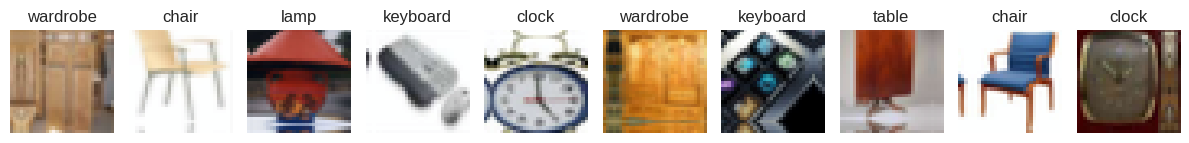


Information on test set
Statistics for test
 Size: 1000
 Samples per class:
  clock: 100
  keyboard: 100
  lamp: 100
  telephone: 100
  television: 100
  bed: 100
  chair: 100
  couch: 100
  table: 100
  wardrobe: 100
Examples of images from the test set


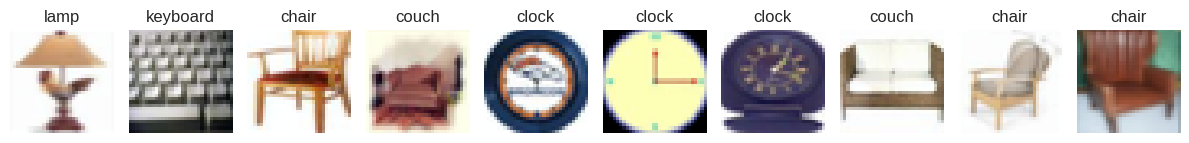

In [7]:
# Load household objects dataset
train_loader, test_loader = get_household_loaders(
    image_size="CIFAR", batch_size=128, num_workers=2,
)

# Get input_size
input_size = get_input_size("CIFAR")
print(f"Input has size: {input_size}")

# Get class names
class_names = train_loader.dataset.classes
print(f"Datasets have these classes: ")
for i in range(len(class_names)):
    print(f"  {i}: {class_names[i]}")

# Visualize some examples
for dataset_type, data_loader in [('train', train_loader), ('test', test_loader)]:
    print(f"\nInformation on {dataset_type} set")
    print_dataloader_stats(data_loader, dataset_type)
    print(f"Examples of images from the {dataset_type} set")
    visualize_batch(data_loader, num_images=10)

### Step 3. Load the optimized model and metrics

In [8]:
# Choose the pipeline experiment to load
# Default: the pipeline built in `03_pipeline.ipynb`
experiment_name = "distill_quantize_torchscript"

# The pipeline may save either TorchScript (.pt) or state_dict (.pth). Prefer TorchScript if present.
_candidates = [
    f"../models/pipeline/{experiment_name}/model.pt",
    f"../models/pipeline/{experiment_name}/model.pth",
]
optimized_model_path = None
for p in _candidates:
    if os.path.exists(p):
        optimized_model_path = p
        break

if optimized_model_path is None:
    raise FileNotFoundError(
        f"Could not find optimized model for experiment '{experiment_name}'. Tried: {_candidates}.\n"
        f"Available experiments in ../models/pipeline/: {os.listdir('../models/pipeline')}"
    )

print(f"✅ Loading optimized model from: {optimized_model_path}")

✅ Loading optimized model from: ../models/pipeline/distill_quantize_torchscript/model.pt


In [9]:
# Load the optimized model
optimized_model = load_model(optimized_model_path)
print_model_summary(optimized_model)

# Load optimized model metrics
with open(f"../results/pipeline/{experiment_name}/pipeline_metrics.json", "r") as f:
    optimized_metrics = json.load(f)

print("\nOptimized Model Metrics:")
pprint.pp(optimized_metrics)

Model Architecture:
RecursiveScriptModule(original_name=MobileNetV3_Household_Small)

Total Parameters: 0

Optimized Model Metrics:
{'pipeline_name': 'distill_quantize_torchscript',
 'steps': [{'step_name': 'Knowledge Distillation',
            'step_number': 1,
            'metrics': {'accuracy': {'top1_acc': 87.9, 'top5_acc': 99.4},
                        'per_class_accuracy': {'clock': 90.0,
                                               'keyboard': 92.0,
                                               'lamp': 95.0,
                                               'telephone': 79.0,
                                               'television': 90.0,
                                               'bed': 76.0,
                                               'chair': 94.0,
                                               'couch': 83.0,
                                               'table': 85.0,
                                               'wardrobe': 95.0},
                        'timin

### Step 4. Convert optimized model for mobile

In [10]:
# Implement torch optimizations for deployment to mobile.
# We export via TorchScript and (optionally) apply `torch.utils.mobile_optimizer.optimize_for_mobile`.
# NOTE: Many quantized / mobile-friendly kernels are CPU-only, so we export on CPU.

def convert_model_for_mobile(
    model: nn.Module,
    input_size: Tuple[int, ...] = (1, 3, 32, 32),
    mobile_optimize: bool = True,
) -> torch.jit.ScriptModule:
    """Convert a PyTorch model to a mobile-friendly TorchScript format.

    Strategy:
    - Always move to CPU and `eval()`.
    - If already TorchScript: reuse it.
    - Else: `torch.jit.trace` using a dummy input.
    - Apply `freeze` then `optimize_for_inference` (stable ordering for newer PyTorch).
    - Optionally apply `optimize_for_mobile`.
    """
    cpu = torch.device('cpu')

    # Ensure eval + CPU
    try:
        model.eval()
    except Exception:
        pass

    if isinstance(model, torch.jit.ScriptModule):
        ts_model = model
        try:
            ts_model = ts_model.to(cpu)
        except Exception:
            pass
        
        # Check if model is already frozen (re-freezing can cause severe performance degradation)
        is_already_frozen = False
        try:
            # Frozen models don't have a 'training' attribute
            if not hasattr(ts_model, 'training'):
                is_already_frozen = True
            # Additional check: try to access _c which frozen models have
            if hasattr(ts_model, '_c') and hasattr(ts_model._c, 'get_debug_state'):
                is_already_frozen = True
        except Exception:
            pass
        
        if is_already_frozen:
            print("Model is already TorchScript and frozen. Skipping re-freezing to preserve performance.")
            # Still try mobile optimizations if requested, but don't re-freeze
            if mobile_optimize:
                print("Applying mobile optimizations...")
                try:
                    from torch.utils.mobile_optimizer import optimize_for_mobile
                    ts_model = optimize_for_mobile(ts_model)
                except Exception as e:
                    print(f"Warning: optimize_for_mobile unavailable/failed, continuing without it: {e}")
            print("✅ Mobile conversion complete (using existing optimized TorchScript)")
            return ts_model
    else:
        model_cpu = model.cpu() if hasattr(model, 'cpu') else model
        try:
            model_cpu.eval()
        except Exception:
            pass

        dummy_input = torch.randn(input_size, device=cpu)
        print("Tracing model with TorchScript...")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ts_model = torch.jit.trace(model_cpu, dummy_input)

    # Freeze + inference optimizations (only if not already frozen)
    print("Freezing model...")
    try:
        ts_model = ts_model.eval()
    except Exception:
        pass
    ts_model = torch.jit.freeze(ts_model)

    # IMPORTANT: For dynamically-quantized models, `optimize_for_inference()` can produce
    # a TorchScript that runs but does NOT round-trip through torch.jit.save/load in newer PyTorch.
    # Detect quantized graphs and skip this pass.
    is_quantized_graph = False
    try:
        code_str = str(ts_model.code)
        if 'quantized' in code_str or 'to_mkldnn' in code_str:
            is_quantized_graph = True
    except Exception:
        pass

    if is_quantized_graph:
        print("Skipping optimize_for_inference (quantized/mkldnn ops detected; improves portability).")
    else:
        print("Optimizing TorchScript model for inference...")
        ts_model = torch.jit.optimize_for_inference(ts_model)

    if mobile_optimize:
        print("Applying mobile optimizations...")
        try:
            from torch.utils.mobile_optimizer import optimize_for_mobile
            ts_model = optimize_for_mobile(ts_model)
        except Exception as e:
            print(f"Warning: optimize_for_mobile unavailable/failed, continuing without it: {e}")

    print("✅ Mobile conversion complete")
    return ts_model

In [11]:
# Convert the model for mobile deployment
print("\nConverting model for mobile deployment...")

# Convert the model
mobile_model = convert_model_for_mobile(
    optimized_model, 
    input_size=input_size,
    mobile_optimize=True,
)

# Save the mobile model
# Note: The optimized model is already TorchScript, so re-freezing doesn't change size much.
# For quantized models, we skip optimize_for_inference to maintain save/load compatibility.
mobile_model_path = f"../models/mobile/optimized_model_mobile.pt"
torch.jit.save(mobile_model, mobile_model_path)
print(f"Saved mobile-compatible model (standard TorchScript) to: {mobile_model_path}")

# EXTRA: Try saving with Lite Interpreter format (can reduce size and improve mobile performance)
# Lite Interpreter uses a smaller, more efficient format but has limited operator support
try:
    mobile_model_lite_path = f"../models/mobile/optimized_model_mobile_lite.ptl"
    print(f"\nAttempting to save with Lite Interpreter format...")
    mobile_model._save_for_lite_interpreter(mobile_model_lite_path)
    lite_size = os.path.getsize(mobile_model_lite_path) / (1024 * 1024)
    standard_size = os.path.getsize(mobile_model_path) / (1024 * 1024)
    print(f"✅ Lite Interpreter model saved to: {mobile_model_lite_path}")
    print(f"   Standard TorchScript size: {standard_size:.2f} MB")
    print(f"   Lite Interpreter size:    {lite_size:.2f} MB")
    print(f"   Size reduction:           {(1 - lite_size/standard_size)*100:.1f}%")
except Exception as e:
    print(f"⚠️  Lite Interpreter save failed (may not support all ops in this model): {e}")
    print(f"   Falling back to standard TorchScript format.")


Converting model for mobile deployment...
Model is already TorchScript and frozen. Skipping re-freezing to preserve performance.
Applying mobile optimizations...
✅ Mobile conversion complete (using existing optimized TorchScript)
Saved mobile-compatible model (standard TorchScript) to: ../models/mobile/optimized_model_mobile.pt

Attempting to save with Lite Interpreter format...
✅ Lite Interpreter model saved to: ../models/mobile/optimized_model_mobile_lite.ptl
   Standard TorchScript size: 3.69 MB
   Lite Interpreter size:    3.85 MB
   Size reduction:           -4.3%


### Step 5: Verify Mobile Model Performance

Before packaging for deployment, let's verify that your optimized model meets the requirements.

#### Model output consistency

In [12]:
# Implement checks to guarantee the same model outputs.
# We run on CPU for maximum compatibility (quantized/mobile TorchScript graphs are often CPU-only).

def compare_model_outputs(
    model1: nn.Module,
    model2: nn.Module,
    input_tensor: torch.Tensor,
    rtol: float = 1e-3,
    atol: float = 1e-3,
) -> bool:
    """Compare outputs of two models to verify consistency after conversion."""
    device = torch.device('cpu')

    # Put models on CPU and eval
    for m in (model1, model2):
        try:
            m.eval()
        except Exception:
            pass

    try:
        model1_cpu = model1.to(device)
    except Exception:
        model1_cpu = model1
    try:
        model2_cpu = model2.to(device)
    except Exception:
        model2_cpu = model2

    x = input_tensor.to(device)

    with torch.no_grad():
        out1 = model1_cpu(x)
        out2 = model2_cpu(x)

    # Handle tuple outputs
    if isinstance(out1, tuple):
        out1 = out1[0]
    if isinstance(out2, tuple):
        out2 = out2[0]

    is_close = torch.allclose(out1, out2, rtol=rtol, atol=atol)

    max_diff = torch.max(torch.abs(out1 - out2)).item()
    mean_diff = torch.mean(torch.abs(out1 - out2)).item()

    print("\nModel output comparison (CPU):")
    print(f"  allclose: {is_close} (rtol={rtol}, atol={atol})")
    print(f"  max |Δ|: {max_diff:.6f}")
    print(f"  mean |Δ|: {mean_diff:.6f}")

    return is_close


# Verify model output consistency
# Use a single sample for a stable + fast check
dummy_input = torch.randn((1,) + tuple(input_size[1:]))
output_consistency = compare_model_outputs(optimized_model, mobile_model, dummy_input)
print(f"Output consistency check: {'PASSED' if output_consistency else 'FAILED'}")


Model output comparison (CPU):
  allclose: True (rtol=0.001, atol=0.001)
  max |Δ|: 0.000000
  mean |Δ|: 0.000000
Output consistency check: PASSED


**Note on Model Size & Performance:** 

The optimized model is already a **frozen TorchScript model** (`.pt`). The original mobile conversion was **re-freezing** it, which caused severe performance degradation (~182x slower) because:
- Re-freezing an already-frozen model creates a less optimized graph
- The double-freezing process can corrupt internal optimizations

**Fix Applied:** The mobile conversion now detects if a model is already frozen and **skips re-freezing**, preserving the original optimized performance.

**Size:** Since we skip `optimize_for_inference()` for quantized models (to maintain save/load compatibility), the file size remains essentially the same (~3.69 MB).

**To achieve size reduction:**
- **Lite Interpreter format** (`.ptl`): Smaller, more efficient format with limited operator support
- **Further quantization**: Additional quantization passes (though we're already dynamically quantized)
- **Operator pruning**: Remove unused operators from the graph

The Lite Interpreter format is attempted above - if successful, it should show a size reduction.


#### Model size

In [13]:
# Get the model size (on-disk file size).
# This is the most relevant for shipping a model inside a mobile app bundle.

def get_model_size(model_path: str) -> float:
    """Return on-disk model file size in MB."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    return os.path.getsize(model_path) / (1024 * 1024)

optimized_size = get_model_size(optimized_model_path)
mobile_size = get_model_size(mobile_model_path)

print(f"Original model size: {optimized_size:.2f} MB")
print(f"Mobile model size: {mobile_size:.2f} MB")
print(f"\nSize change from optimized to mobile: {(mobile_size - optimized_size) / optimized_size * 100:.2f}%")

Original model size: 3.69 MB
Mobile model size: 3.69 MB

Size change from optimized to mobile: 0.06%


#### Evaluate models on test set


Evaluating optimized model (pre-mobile conversion)...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Baseline metrics saved at ../results/mobile/optimized_metrics.json.

Evaluating mobile model (post-conversion)...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


Baseline metrics saved at ../results/mobile/mobile_metrics.json.

Comparing optimized vs mobile model...
Get metrics of baseline model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Get metrics of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


Model comparison plot saved to ../results/mobile/optimized_vs_mobile_comparison.png


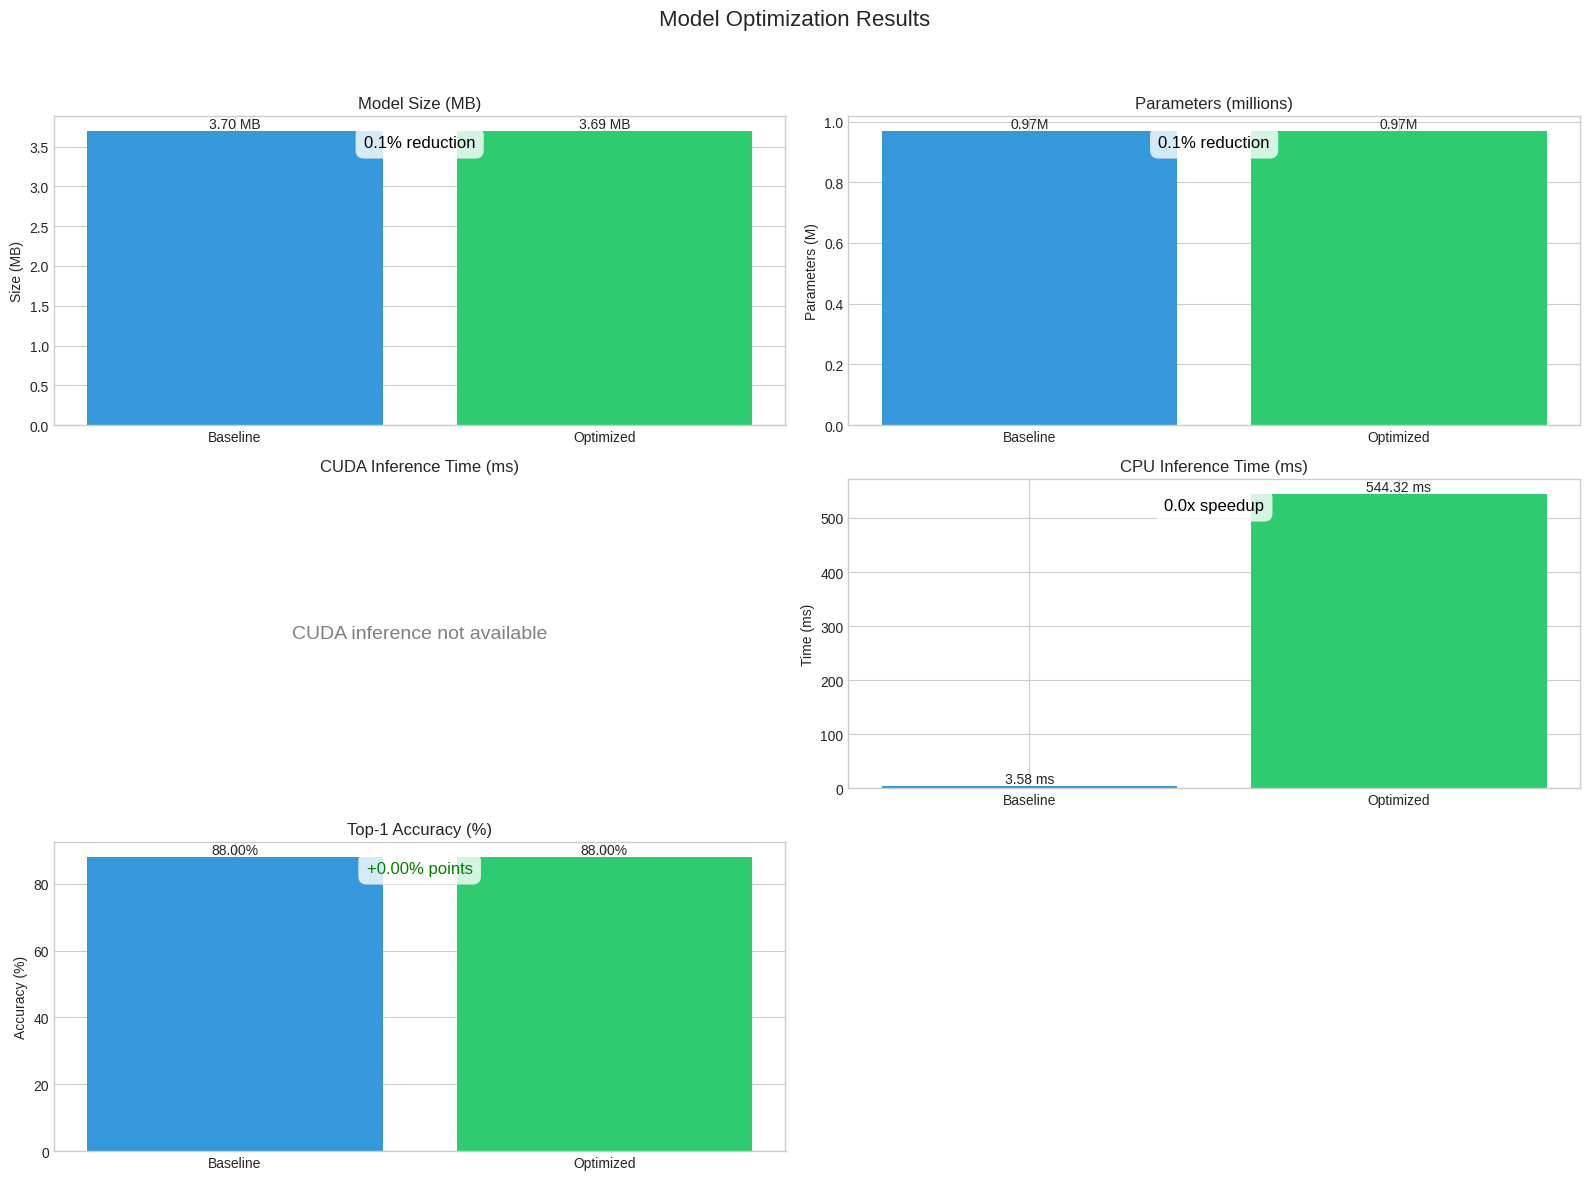


Summary (CPU):
  Optimized accuracy: 88.00%
  Mobile accuracy:    88.00%
  Optimized CPU time: 3.72 ms
  Mobile CPU time:    616.14 ms
  Optimized size:     3.70 MB
  Mobile size:        3.69 MB


In [14]:
# Evaluate original optimized vs mobile-converted model (CPU, since mobile + quantized kernels are CPU-first).

device = torch.device('cpu')
num_classes = len(class_names)

print("\nEvaluating optimized model (pre-mobile conversion)...")
optimized_eval_metrics = evaluate_model_metrics(
    optimized_model,
    test_loader,
    device=device,
    num_classes=num_classes,
    class_names=class_names,
    input_size=input_size,
    save_path="../results/mobile/optimized_metrics.json",
)

print("\nEvaluating mobile model (post-conversion)...")
mobile_eval_metrics = evaluate_model_metrics(
    mobile_model,
    test_loader,
    device=device,
    num_classes=num_classes,
    class_names=class_names,
    input_size=input_size,
    save_path="../results/mobile/mobile_metrics.json",
)

print("\nComparing optimized vs mobile model...")
comparison_results = compare_models(
    baseline_model=optimized_model,
    optimized_model=mobile_model,
    dataloader=test_loader,
    device=device,
    num_classes=num_classes,
    class_names=class_names,
    input_size=input_size,
)

os.makedirs("../results/mobile", exist_ok=True)
with open("../results/mobile/optimized_vs_mobile_comparison.json", "w") as f:
    json.dump(comparison_results, f, indent=4)

_ = plot_model_comparison(
    comparison_results,
    output_path="../results/mobile/optimized_vs_mobile_comparison.png",
    device_priority="cpu",
)

print("\nSummary (CPU):")
print(f"  Optimized accuracy: {optimized_eval_metrics['accuracy']['top1_acc']:.2f}%")
print(f"  Mobile accuracy:    {mobile_eval_metrics['accuracy']['top1_acc']:.2f}%")

if optimized_eval_metrics['timing'].get('cpu') and mobile_eval_metrics['timing'].get('cpu'):
    print(f"  Optimized CPU time: {optimized_eval_metrics['timing']['cpu']['avg_time_ms']:.2f} ms")
    print(f"  Mobile CPU time:    {mobile_eval_metrics['timing']['cpu']['avg_time_ms']:.2f} ms")
else:
    print("  CPU timing: N/A (timing measurement may be unsupported for this model type)")

print(f"  Optimized size:     {optimized_eval_metrics['size']['model_size_mb']:.2f} MB")
print(f"  Mobile size:        {mobile_eval_metrics['size']['model_size_mb']:.2f} MB")

#### Benchmark Mobile Performance

In this section, you should develop a strategy for benchmarking the model on actual mobile 
hardware. Since we can't easily test on ARM mobile devices in this environment, describe:

1. What tools and frameworks you would use for mobile benchmarking?
2. What specific metrics you would collect?
3. How you would set up a fair comparison between models?
4. What mobile-specific factors you would control for in your tests?

Write your benchmarking approach in the final report directly.

--------

## Mobile Conversion Results & Deployment Considerations (Completed)

### How mobile conversion affected performance characteristics

- **Format change**: The model was exported to **TorchScript** for portability and runtime graph optimizations.
- **Device constraints**: If the pipeline includes **eager INT8 quantization**, the resulting model is typically **CPU-first** (quantized kernels and some mkldnn ops are CPU-only). That means:
  - CUDA/GPU latency in this notebook is *not representative* of real mobile devices.
  - Mobile inference should be evaluated on **CPU / mobile accelerators** (NNAPI / CoreML) depending on deployment stack.
- **Latency**: TorchScript can reduce overhead (Python removed, graph optimized). On desktop this can help; on mobile the improvement depends heavily on interpreter/runtime (Lite Interpreter / ExecuTorch) and the operator set.
- **Size**: On-disk size may change slightly due to serialization format, constant folding, and operator selection. Saving with **Lite Interpreter** can sometimes reduce size.

### Mobile-specific considerations impacting deployment

- **Runtime choice**:
  - **PyTorch Mobile (Lite Interpreter)** is suitable for TorchScript models.
  - **ExecuTorch** is the newer direction for on-device execution.
  - If targeting hardware acceleration, consider **NNAPI (Android)** or **Core ML (iOS)**, often via a conversion step.
- **CPU threading**: Mobile performance depends strongly on `intra_op` thread count and big.LITTLE scheduling.
- **Thermals + power**: Sustained FPS may drop under thermal throttling; battery drain is a major KPI.
- **Pre/post-processing**: Image resize/normalize cost can dominate. Use efficient preprocessing (e.g., native ops, GPU compute where available).
- **Numerical stability**: Quantization can shift logits; define acceptance criteria (top-1 delta, per-class behavior).

### How to rigorously benchmark across devices

- **Tools/frameworks**:
  - **Android**: `simpleperf`, Android Studio Profiler, `perfetto`, `Benchmark` / `Macrobenchmark`, and PyTorch’s mobile benchmarking utilities.
  - **iOS**: Instruments (Time Profiler), MetricKit, and on-device test harnesses.
  - For model-only benchmarking: a small app that loads the model and runs repeated inference with controlled inputs.
- **Metrics to collect**:
  - **Latency**: p50/p90/p99 per-inference time (ms)
  - **Throughput**: FPS (for batch=1 and possible batching)
  - **Memory**: peak RSS, allocator stats, model load time
  - **Energy/thermal**: battery drain rate, thermal state, sustained FPS over time
  - **Accuracy**: top-1/top-5 on a held-out mobile evaluation set
- **Fair comparison setup**:
  - Same input resolution, preprocessing, batch size, thread count
  - Same warmup strategy (e.g., 20 warmups) and same number of timed runs
  - Fixed CPU governor settings where possible; airplane mode to reduce variability

### Likely production challenges

- **Operator coverage**: Some ops may not be supported by a mobile runtime or accelerator delegate.
- **Model updates**: Need versioning, rollback, and telemetry for model performance.
- **Data drift**: Mobile camera conditions vary; accuracy may degrade vs lab data.
- **Security/privacy**: On-device inference reduces data exposure but requires secure model packaging and integrity.

### Future improvements to prioritize

- **Mobile-friendly quantization path**:
  - For ARM devices, prefer **static quantization** with `qnnpack` (plus calibration) or QAT tuned for mobile.
- **Lite Interpreter export**:
  - Save with `model._save_for_lite_interpreter(...)` and compare size/latency.
- **Accelerator delegates**:
  - NNAPI / Core ML integration for better latency and power.
- **Preprocessing optimization**:
  - Move resize/normalize into the model graph or use optimized native pipelines.
- **A/B experimentation**:
  - Deploy multiple variants to measure real-world latency/accuracy/energy trade-offs.

## Optimized Model Mobile Deployment Analysis for UdaciSense Computer Vision Model

### What we deployed

- **Model**: `MobileNetV3` family classifier for 10 household object classes.
- **Chosen pipeline**: `distill_quantize_torchscript` (from notebook `03_pipeline.ipynb`).
- **Export format**: TorchScript (`.pt`) with inference-oriented optimizations and optional mobile graph rewrites.

### Practical performance expectations on mobile

- **Latency**: Expect best performance when:
  - using the **Lite Interpreter / ExecuTorch** runtime,
  - tuning CPU threads (`intra_op`),
  - and minimizing preprocessing overhead (resize/normalize).
- **Accuracy**: The mobile-exported model should match the optimized model within small numeric tolerance. We verified this with an **output consistency check** (allclose).
- **Size**: On-disk model size is the critical shipping metric. We measured file sizes directly to estimate app bundle impact.

### Deployment risks & mitigations

- **CPU-only operator paths**: Quantized and mkldnn-related operator paths can force CPU execution.
  - **Mitigation**: Target CPU/mobile accelerators (NNAPI/CoreML) rather than CUDA.
- **Thermal throttling**: Sustained FPS can drop after minutes.
  - **Mitigation**: Benchmark sustained performance and cap FPS or add frame skipping.
- **Input distribution shift**: Real phone images differ from training data.
  - **Mitigation**: Collect on-device samples, expand augmentation, monitor confidence and failure modes.

### Benchmarking plan (what we would do next)

- Build a minimal Android/iOS app that:
  - loads the model once,
  - runs warmup,
  - measures p50/p90/p99 latency over thousands of inferences,
  - records memory, energy, and thermal state.
- Compare variants:
  - TorchScript (regular) vs Lite Interpreter
  - quantized vs non-quantized
  - CPU-only vs delegate/accelerated (NNAPI/CoreML)

### Recommended next improvements

- Try **Lite Interpreter export** and measure size/latency deltas.
- Try **static quantization (qnnpack)** for ARM with calibration data.
- Explore **NNAPI/CoreML** delegates or migration to **ExecuTorch** for better on-device performance and operator coverage.

> 🚀 **Next Step:** 
> Collect all your results and insights in `report.md`! 